<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

In [3]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [4]:
!wget --header="Host: doc-0o-bk-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.212 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Cookie: AUTH_nso6dcn1mbidkt5qr539a2jiefc09pqv_nonce=iak2ig7rpq664" --header="Connection: keep-alive" "https://doc-0o-bk-docs.googleusercontent.com/docs/securesc/nss2f5s2soorprev6d4t4qp3n5ekp9nh/evl2j2j4t5hronicnhsbdlsblnbl9qk3/1622116650000/06629147635963609455/13017565264516993811/1fDJptlCFEWNV5UNGPc4geTykgFI3PDCV?e=download&authuser=0&nonce=iak2ig7rpq664&user=13017565264516993811&hash=fvl5s6dohfnqle6k8q3koe9jr2mhe6jr" -c -O 'storage_sample_stage4.h5'

--2022-04-25 16:17:48--  https://doc-0o-bk-docs.googleusercontent.com/docs/securesc/nss2f5s2soorprev6d4t4qp3n5ekp9nh/evl2j2j4t5hronicnhsbdlsblnbl9qk3/1622116650000/06629147635963609455/13017565264516993811/1fDJptlCFEWNV5UNGPc4geTykgFI3PDCV?e=download&authuser=0&nonce=iak2ig7rpq664&user=13017565264516993811&hash=fvl5s6dohfnqle6k8q3koe9jr2mhe6jr
Resolving doc-0o-bk-docs.googleusercontent.com (doc-0o-bk-docs.googleusercontent.com)... 142.250.192.161
Connecting to doc-0o-bk-docs.googleusercontent.com (doc-0o-bk-docs.googleusercontent.com)|142.250.192.161|:443... connected.
OpenSSL: error:1408F10B:SSL routines:ssl3_get_record:wrong version number
Unable to establish SSL connection.


In [6]:
#reading
from pandas import read_hdf
df_final_train = read_hdf('storage_sample_stage6.h5', 'train_df',mode='r')
df_final_test = read_hdf('storage_sample_stage6.h5', 'test_df',mode='r')

In [7]:
df_final_test.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'pref_attachment_followers', 'pref_attachment_followees', 'svd_u_dot_1',
       'svd_v_dot_1'],
      dtype='object')

In [8]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [9]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

Estimators =  10 Train Score 0.9656499372139183 test Score 0.9270200374256219
Estimators =  40 Train Score 0.9784716051377332 test Score 0.9293823604168431
Estimators =  50 Train Score 0.9804253774241369 test Score 0.9284881873079776
Estimators =  80 Train Score 0.985748051294946 test Score 0.9216585927996755
Estimators =  100 Train Score 0.9886793969041616 test Score 0.9171630597814442


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

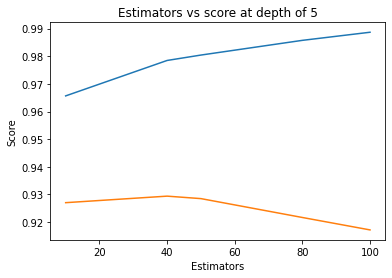

In [10]:
estimators = [10,40,50,80,100]
train_scores = []
test_scores = []
for i in estimators:
    clf = xgb.XGBClassifier(
            max_depth=5, 
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbosity=0)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

depth =  3 Train Score 0.9744966171048901 test Score 0.9262361294162662
depth =  9 Train Score 0.9908175772066949 test Score 0.9285563037309956
depth =  11 Train Score 0.9966341434095325 test Score 0.9273162769993852
depth =  15 Train Score 0.9999900098902087 test Score 0.9272892957806176
depth =  20 Train Score 1.0 test Score 0.9289129606905597
depth =  35 Train Score 1.0 test Score 0.9304408440886336
depth =  50 Train Score 1.0 test Score 0.9304408440886336
depth =  70 Train Score 1.0 test Score 0.9304408440886336


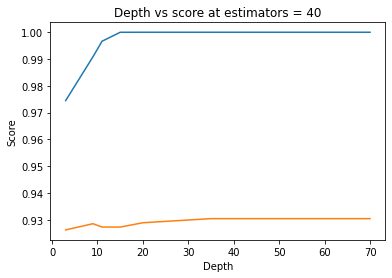

In [12]:
depths = [3,9,11,15,20,35,50,70]
train_scores = []
test_scores = []
for i in depths:
    clf = xgb.XGBClassifier(
            max_depth=i, 
            n_estimators=40, n_jobs=-1,random_state=25,verbosity=0)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at estimators = 40')
plt.show()

In [13]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(30,50),
              "max_depth": sp_randint(25,40),
             }

clf = xgb.XGBClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25,return_train_score=True)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.97917735 0.97897337 0.97875715 0.97851631 0.97865283]
mean train scores [1. 1. 1. 1. 1.]


In [14]:
print(rf_random.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=29,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=45, n_jobs=-1, num_parallel_tree=1, random_state=25,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [15]:
clf = xgb.XGBClassifier(
            max_depth=29,
            n_estimators=45, n_jobs=-1,
            random_state=25, verbosity=0)

In [16]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [17]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 1.0
Test f1 score 0.9308800540791753


In [20]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


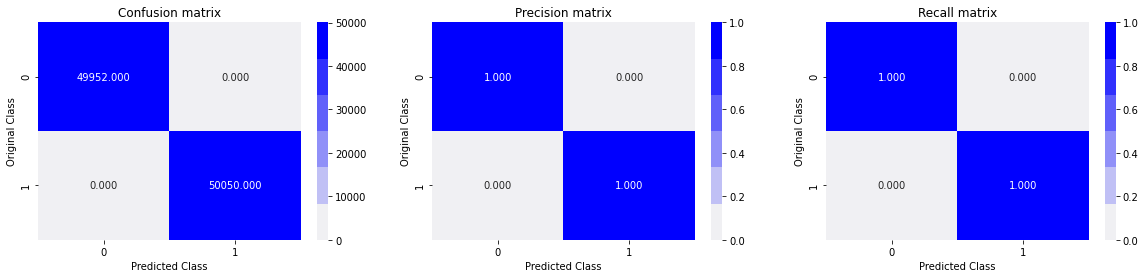

Test confusion_matrix


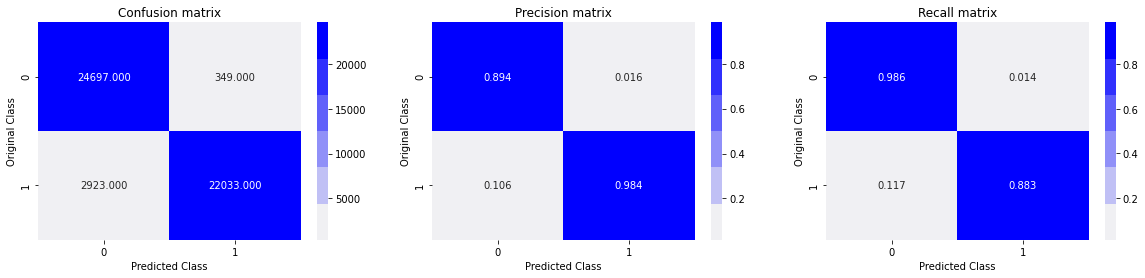

In [21]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

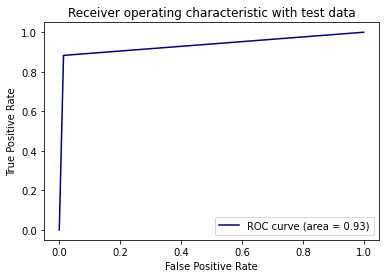

In [22]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

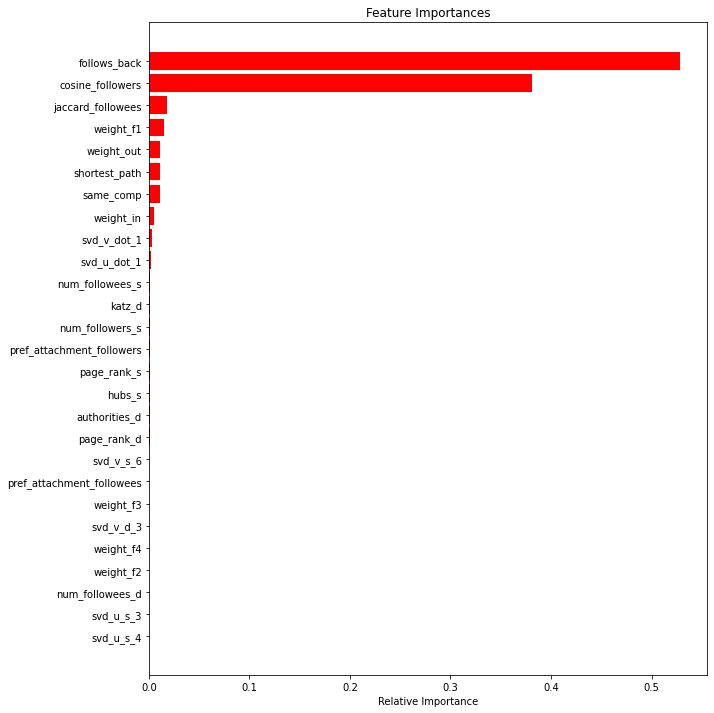

In [23]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-27:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Assignments:

1. Add another feature called  Preferential Attachment  with followers and followees data of vertex. you can check about Preferential Attachment in below link
http://be.amazd.com/link-prediction/ <br>
2. Add  feature called svd_dot. you can calculate svd_dot as Dot product between sourse node svd and destination node svd features.  you can read about this in below pdf 
https://storage.googleapis.com/kaggle-forum-message-attachments/2594/supervised_link_prediction.pdf<br>
3. Tune hyperparameters for XG boost with all these features and check the error metric.